# Выбор локации для скважины

**1. Цель исследования:**
Цель исследования — выбрать наиболее подходящий регион для разработки нефтяных скважин. Необходимо построить модель машинного обучения, которая сможет предсказать объём нефти в каждой скважине, и провести анализ потенциальной прибыли и рисков, связанных с разработкой каждого региона. Основная задача заключается в выборе региона, который принесёт максимальную прибыль при минимальном риске.

**2. План исследования:**
1. **Загрузка и подготовка данных**:
   - Загрузить данные по трём регионам.
   - Разделить данные на обучающую и валидационную выборки в пропорции 75:25.
   
2. **Обучение модели для каждого региона**:
   - Обучить модель линейной регрессии на каждом регионе.
   - Провести предсказания на валидационной выборке и сохранить результаты.
   - Оценить качество модели по среднему значению предсказаний и метрике RMSE.
   
3. **Подготовка к расчёту прибыли**:
   - Рассчитать минимальный объём нефти для безубыточной разработки.
   - Сравнить средний объём нефти в каждом регионе с безубыточным уровнем.
   
4. **Расчёт прибыли**:
   - Выбрать 200 скважин с максимальными прогнозами объёмов нефти для каждого региона.
   - Рассчитать суммарный объём нефти и прибыль для каждой группы скважин.
   
5. **Анализ рисков**:
   - Применить технику Bootstrap для оценки распределения прибыли и рисков.
   - Определить среднюю прибыль, доверительный интервал и вероятность убытков.
   
6. **Вывод**:
   - Сделать заключение о выборе региона с наибольшей средней прибылью и минимальными рисками.

**3. Шаги для выбора локации:**
1. Собрать данные о характеристиках скважин в каждом регионе (качество нефти и объём запасов).
2. Построить модель для предсказания объёма запасов нефти.
3. Выбрать 200 скважин с наибольшими прогнозируемыми объёмами.
4. Рассчитать суммарную прибыль от выбранных скважин.
5. Проанализировать риски и определить регион с наибольшей потенциальной прибылью.

**4. Условия задачи:**
1. Для обучения модели используется только линейная регрессия.
2. В каждом регионе исследуется 500 скважин, из которых выбирается 200 для разработки.
3. Бюджет на разработку составляет 10 миллиардов рублей.
4. Прибыль с одного барреля нефти составляет 450 тысяч рублей.
5. Необходимо выбрать регион, в котором вероятность убытков меньше 2.5%.

**5. Описание данных:**
- **id** — уникальный идентификатор скважины.
- **f0, f1, f2** — три признака, характеризующие скважину (например, физические или химические параметры).
- **product** — объём нефти в скважине (в тысячах баррелей).

Данные представлены по трём регионам, и необходимо определить, в каком из них разработка будет наиболее выгодной.

## 1. Загрузка и подготовка данных

### 1.1. Общая информация

#### 1.1.1. Импорт

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
simplefilter(action='ignore', category=FutureWarning)


#### 1.1.2. Константы

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
line_1 = '-'*90 #линия 
line_2 = '_'*90#линия
#_____________________________
#Для расчета прибыли
TOTAL_BUDGET = 10000000000
SELECTING_WELLS_COUNT = 500
BEST_WELLS_COUNT = 200
INCOME_FROM_ONE_UNIT = 450000


#### 1.1.3. Функции

##### 1.1.3.1. Функция для получения общей информации о датасете

In [11]:
# Напишем функцию для получения общей информации о датасете
def get_info(data):
    display(data.head())
    print(line_1)
    display(data.info())
    display(data.describe())
    print(line_1)
    id_duplicates = data['id'].value_counts()
    print(line_1)
    
    print('Кол-во неявных дубликатов в столбце id:', len(data) - id_duplicates.count())
    data = data.drop_duplicates(subset='id', keep='first')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('Кол-во пропусков:\n',  data.isna().sum())
    print(line_1)
    display(data.info())
    
    plt.hist(data['product'], color = 'orange', edgecolor = 'orange', bins = 1000)
    x_axis = np.arange(0, 200, 20)
    y_axis = np.arange(0, 500, 50)
    plt.xticks(x_axis)
    plt.yticks(y_axis)
    plt.ylim(0, 200)
    plt.title('Распределение целевой переменной product:')
    plt.xlabel('Значение переменной')
    plt.show()

    return data  # Возвращаем обновлённый набор данных



##### 1.1.3.2. Функция для обучения модели и оценки её качества с использованием кросс-валидации.

In [13]:
def m_l(features, target, region_name):
    """
    Функция для обучения модели и расчёта метрик. Без вывода на экран.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Масштабирование данных (стандартизация)
        ('model', LinearRegression())  # Модель линейной регрессии
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Средний запас сырья (среднее значение предсказаний)
    avg_predicted_reserves = np.mean(y_pred)

    # RMSE на тестовой выборке
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Кросс-валидация для оценки модели
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Средний MSE на кросс-валидации
    avg_mse = -scores.mean()

    
    # Возвращаем средний запас сырья, RMSE и средний MSE
    return avg_predicted_reserves, rmse, avg_mse, y_pred, y_test

##### 1.1.3.3. Функция вывода обучения ML-модели в разрезе регионов

In [15]:
def process_region_data_with_metrics(regions):
    """
    Функция, которая для каждого региона выводит метрики модели и предсказания.
    """
    for region_name, (features, target) in regions.items():
        print(f"Обрабатываем регион: {region_name}")
        
        # Вызов функции m_l для получения метрик и предсказаний
        avg_predicted_reserves, rmse, avg_mse, y_pred, y_test = m_l(features, target, region_name)
        
        # Вывод метрик
        print(f"Средний запас сырья (avg_predicted_reserves): {avg_predicted_reserves}")
        print(f"RMSE модели: {rmse}")
        print(f"Средний MSE на кросс-валидации: {avg_mse}")
        
        # Сохранение предсказанных и реальных значений в переменные (при необходимости)
        predicted_values = y_pred  # Предсказанные значения модели
        actual_values = y_test  # Реальные значения целевой переменной
        
        # Вывод первых 5 предсказанных и реальных значений
        print(f"Первые 5 предсказанных значений (y_pred): {predicted_values[:5]}")
        print(f"Первые 5 реальных значений (y_test): {actual_values[:5]}")
        
        print("-" * 40)

##### 1.1.3.4. Функция для сравнения среднего запаса по каждому региону с достаточным объёмом сырья для безубыточной разработки

In [17]:
def compare_avg_reserves(sufficient_volume, avg_reserves_list):
    """
    Функция для сравнения среднего запаса по каждому региону с достаточным объёмом сырья для безубыточной разработки.
    
    :param sufficient_volume: Достаточный объём сырья для безубыточной разработки (тыс. баррелей)
    :param avg_reserves_list: Словарь с регионами и их средними запасами (тыс. баррелей)
    """
    
    # Проходим по каждому региону в словаре и сравниваем средний запас с достаточным объёмом
    for region, avg_reserves in avg_reserves_list.items():
        if avg_reserves >= sufficient_volume:
            print(f"Средний запас в регионе {region}: {avg_reserves:.2f} тыс. баррелей — достаточно для безубыточной разработки.")
        else:
            print(f"Средний запас в регионе {region}: {avg_reserves:.2f} тыс. баррелей — недостаточно для безубыточной разработки.")


In [18]:
def revenue_all_region_bootstrap(region_list_predicted):
    """
    Функция для расчета прибыли для каждого региона на основе предсказанных значений с использованием Bootstrap.
    
    :param region_list_predicted: Словарь, где ключи — названия регионов, 
                                  а значения — кортежи (y_pred, y_test).
    """
    # Словарь для накопления прибылей всех итераций по каждому региону
    profits_all = {region: [] for region in region_list_predicted.keys()}
    
    # 1000 итераций Bootstrap
    for i in range(1000):
        for region, (y_pred, y_test) in region_list_predicted.items():
            # Преобразование y_pred в pandas.Series с индексами из y_test
            y_pred_series = pd.Series(y_pred, index=y_test.index)
            
            # Проверка на совпадение размеров выборок
            if len(y_test) != len(y_pred_series):
                raise ValueError("Размеры y_test и y_pred должны совпадать")
            
            # Генерация подвыборки для Bootstrap
            target_subsample = y_test.sample(n=SELECTING_WELLS_COUNT, replace=True, random_state=i)
            probs_subsample = y_pred_series[target_subsample.index]
            
            # Сортировка вероятностей по убыванию и выбор лучших 200 скважин
            probs_200_best = probs_subsample.sort_values(ascending=False).head(BEST_WELLS_COUNT)
            
            # Отбор целевых значений по индексу лучших скважин
            selected = target_subsample.loc[probs_200_best.index]
            
            # Вычисление прибыли и добавление в список для данного региона
            profit = selected.sum() * INCOME_FROM_ONE_UNIT - TOTAL_BUDGET
            profits_all[region].append(profit)
    
    # Рассчитываем среднюю прибыль и доверительный интервал по каждому региону
    for region, profits in profits_all.items():
        profits_series = pd.Series(profits)
        mean_profit = profits_series.mean()
        lower = profits_series.quantile(0.025)
        upper = profits_series.quantile(0.975)
        
        # Форматированный вывод для каждого региона
        print(f"Регион: {region}")
        print(f"Средняя прибыль: {mean_profit}")
        print(f"95%-ый доверительный интервал: [{lower}, {upper}]")
        print(f'Риск убытка: {(len(profits_series[profits_series < 0]) / len(profits_series)):.2%}')
        print(line_1)

#### 1.1.3. Загрузка данных

In [20]:
#Данные
try:
    first_geo = pd.read_csv('datasets/geo_data_0.csv')
    second_geo = pd.read_csv('datasets/geo_data_1.csv')
    third_geo = pd.read_csv('datasets/geo_data_2.csv')
except:
    first_geo = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    second_geo = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    third_geo = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### 1.2. Анализ датасетов

#### `first_geo`

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Кол-во неявных дубликатов в столбце id: 10
Кол-во явных дубликатов: 0
Кол-во пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

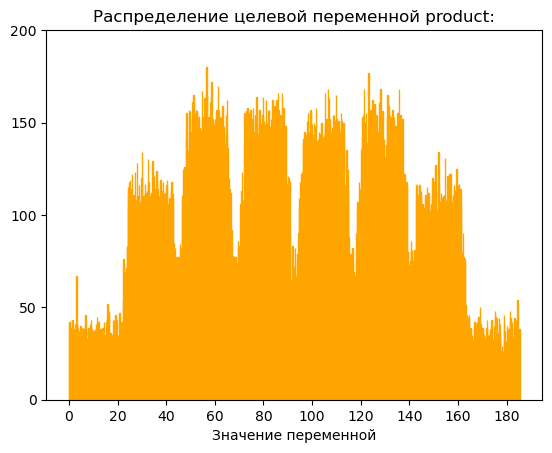

In [23]:
first_geo = get_info(first_geo)

In [24]:
first_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


#### `second_geo`

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Кол-во неявных дубликатов в столбце id: 4
Кол-во явных дубликатов: 0
Кол-во пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

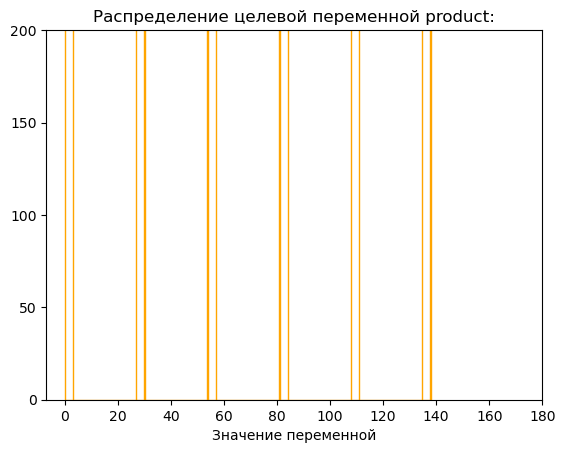

In [26]:
second_geo = get_info(second_geo)

#### `third_geo`

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Кол-во неявных дубликатов в столбце id: 4
Кол-во явных дубликатов: 0
Кол-во пропусков:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


None

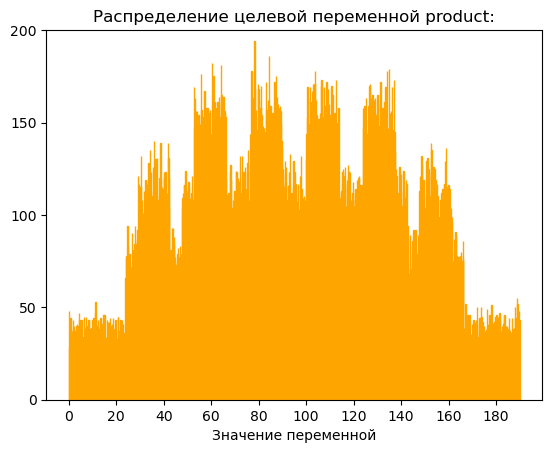

In [28]:
third_geo = get_info(third_geo)

#### Выводы
**`first_geo`**
- **Размер**: 100,000 строк, 5 столбцов, после удаления дубликатов — 99,990 строк.
- **Целевая переменная `product`**:
  - Среднее: 92.5 тыс. баррелей.
  - Диапазон: от 0 до 185.36 тыс. баррелей.
  - Многомодальное распределение с пиками на уровнях 60–130 тыс. баррелей.
- **Дубликаты**: 10 неявных дубликатов, удалено 10 строк.
- **Пропусков**: Нет.

Готово для дальнейшего анализа.
__________________________________________________________________________________________________________________
**`second_geo`**
1. **Размер данных**:
   - 100,000 строк и 5 столбцов.
   - После удаления неявных дубликатов осталось 99,996 строк.

2. **Целевая переменная `product`**:
   - Среднее значение: 68.83 тыс. баррелей.
   - Диапазон значений: от 0 до 137.95 тыс. баррелей.
   - Стандартное отклонение: 45.94, что указывает на значительную вариативность объёмов нефти.
   - Гистограмма показывает проблему с визуализацией, возможно, требуется пересмотреть параметры построения.

3. **Дубликаты и очистка**:
   - Выявлено 4 неявных дубликата, удалено 4 строки.
   - Явных дубликатов нет.

4. **Пропуски**:
   - Пропусков нет.

Данные готовы для дальнейшего анализа.
_______________________________________________________________________________________________________________
**`third_geo`**
1. **Размер данных**:
   - 100,000 строк и 5 столбцов.
   - После удаления неявных дубликатов осталось 99,996 строк.

2. **Целевая переменная `product`**:
   - Среднее значение: 95.0 тыс. баррелей.
   - Диапазон значений: от 0 до 190.03 тыс. баррелей.
   - Стандартное отклонение: 44.75, что указывает на широкий разброс объёмов нефти.
   - Гистограмма показывает многомодальное распределение с пиками в диапазоне от 60 до 130 тыс. баррелей, что может указывать на наличие групп месторождений с разной производительностью.

3. **Дубликаты и очистка**:
   - Найдено 4 неявных дубликата, удалено 4 строки.
   - Явных дубликатов нет.

4. **Пропуски**:
   - Пропусков нет.

Данные хорошо сбалансированы и готовы к дальнейшему анализу.

### 1.3. Подготовка данных к ML

In [31]:
# Индексация датасетов
first_geo = first_geo.set_index('id')
second_geo = second_geo.set_index('id')
third_geo = third_geo.set_index('id')

# Убираем из датасетов целевой признак 'product'
features_first_geo = first_geo.drop('product', axis=1)
features_second_geo = second_geo.drop('product', axis=1)
features_third_geo = third_geo.drop('product', axis=1)

# Отдельно выделяем целевой параметр
target_first_geo = first_geo['product']
target_second_geo = second_geo['product']
target_third_geo = third_geo['product']

In [32]:
#Проверим размерность
for name, dataframe in zip(['features_first_geo', 'features_second_geo', 'features_third_geo','target_first_geo','target_second_geo','target_third_geo'],
                           [features_first_geo, features_second_geo, features_third_geo,target_first_geo,target_second_geo,target_third_geo]):
    print(f"Размер {name}: {dataframe.shape}")

Размер features_first_geo: (99990, 3)
Размер features_second_geo: (99996, 3)
Размер features_third_geo: (99996, 3)
Размер target_first_geo: (99990,)
Размер target_second_geo: (99996,)
Размер target_third_geo: (99996,)


## 2. Машинное обучение (ML)

### 2.1. Обучение модели LinearRegression

In [35]:
# Словарь с данными по регионам
regions = {
    'first_region': (features_first_geo, target_first_geo),
    'second_region': (features_second_geo, target_second_geo),
    'third_region': (features_third_geo, target_third_geo)
}

# Вызов функции для вывода данных и метрик по регионам
process_region_data_with_metrics(regions)

Обрабатываем регион: first_region
Средний запас сырья (avg_predicted_reserves): 92.60984027552017
RMSE модели: 37.68508926201444
Средний MSE на кросс-валидации: 1421.0999118175728
Первые 5 предсказанных значений (y_pred): [127.48652781 116.46583085  66.0419102   45.00938973 124.53555679]
Первые 5 реальных значений (y_test): id
qoTP6    119.813252
fNYo7    133.296862
KpTZ4     25.310435
vGX0w     65.422491
6N2oA    140.851476
Name: product, dtype: float64
----------------------------------------
Обрабатываем регион: second_region
Средний запас сырья (avg_predicted_reserves): 68.57703454115173
RMSE модели: 0.8928265978121422
Средний MSE на кросс-валидации: 0.7914314701366914
Первые 5 предсказанных значений (y_pred): [  1.74563484 135.73089121 133.53965253  28.8445167  138.03718245]
Первые 5 реальных значений (y_test): id
XObi5      0.000000
wc1b3    134.766305
WEK62    134.766305
1A2kd     30.132364
YqOc2    137.945408
Name: product, dtype: float64
---------------------------------------

**Выводы:**
* second_geo имеет наибольшую точность предсказаний, но меньший средний запас нефти.
* first_geo и third_geo имеют схожие высокие запасы, но модели сталкиваются с большими ошибками предсказаний, что может привести к рискам.

## 3. Расчет прибыли

### 3.1. Подготовка

In [39]:
# Расчёт достаточного объёма сырья для безубыточной разработки новой скважины
sufficient_volume = TOTAL_BUDGET / (BEST_WELLS_COUNT * INCOME_FROM_ONE_UNIT)

# Словарь средние запасов по регионам
avg_reserves_list = {
    'first_geo': m_l(features_first_geo, target_first_geo, 'first_geo')[0],  # Средний запас first_geo
    'second_geo': m_l(features_second_geo, target_second_geo, 'second_geo')[0],  # Средний запас second_geo
    'third_geo': m_l(features_third_geo, target_third_geo, 'third_geo')[0]  # Средний запас third_geo
}

# Вызов функции для сравнения
compare_avg_reserves(sufficient_volume, avg_reserves_list)

Средний запас в регионе first_geo: 92.61 тыс. баррелей — недостаточно для безубыточной разработки.
Средний запас в регионе second_geo: 68.58 тыс. баррелей — недостаточно для безубыточной разработки.
Средний запас в регионе third_geo: 94.93 тыс. баррелей — недостаточно для безубыточной разработки.


#### Вывод:
* Все три региона имеют средние запасы сырья ниже уровня безубыточности (111.11 тыс. баррелей).
* Для того чтобы избежать убытков, необходимо выбирать скважины с более высокими запасами, чем средний показатель по региону.
* Необходимо оценить уровень прибыли и рисков убыточности

### 3.2. Расчет рисков и прибыли для каждого регион

In [42]:
# Словарь с предсказаниями по регионам
region_list_predicted = {
    'first_geo': m_l(features_first_geo, target_first_geo, 'first_geo')[-2:],
    'second_geo': m_l(features_second_geo, target_second_geo, 'second_geo')[-2:],
    'third_geo': m_l(features_third_geo, target_third_geo, 'third_geo')[-2:]
}

# Вызов функции для расчета прибыли и вывода результатов
revenue_all_region_bootstrap(region_list_predicted)


Регион: first_geo
Средняя прибыль: 615768237.8328661
95%-ый доверительный интервал: [-1119707.796397248, 1246109887.9965713]
Риск убытка: 2.60%
------------------------------------------------------------------------------------------
Регион: second_geo
Средняя прибыль: 632747181.1855005
95%-ый доверительный интервал: [168509583.09718925, 1140549915.6108665]
Риск убытка: 0.20%
------------------------------------------------------------------------------------------
Регион: third_geo
Средняя прибыль: 572746881.5097297
95%-ый доверительный интервал: [-5734397.638461586, 1224829831.8475718]
Риск убытка: 2.80%
------------------------------------------------------------------------------------------


**Вывод:**
* Наиболее выгодным и наименее рискованным регионом для разработки нефтяных скважин является второй регион (second_geo), так как он сочетает самую высокую среднюю прибыль с низким риском убытка (0.20%), что удовлетворяет условиям проекта.

## Общий вывод по исследованию

В ходе исследования была разработана модель машинного обучения для определения наиболее прибыльного региона для добычи нефти. Проведенный анализ с использованием метода Bootstrap позволил сделать следующие выводы:

**Рекомендованный регион для разработки — регион 2:**
- Низкий риск убытков: всего 0.2% (по сравнению с 2.6% в первом регионе и 2.8% в третьем).
- Ожидаемая средняя прибыль составляет около 632 млн (против 615 млн в первом регионе и 572 млн в третьем).

**Этапы исследования**

1. **Загрузка и подготовка данных:**
   - Выполнен импорт необходимых библиотек и загрузка трех датасетов: `first_geo`, `second_geo`, `third_geo`.
   - Реализована функция `get_info` для проверки данных: проверены типы данных, выявлены и удалены неявные дубликаты, а также подтверждено отсутствие пропусков и явных дубликатов.
   - Из столбца `id` удалены неявные дубликаты: 10 строк из `first_geo`, 4 строк из `second_geo` и 4 строк из `third_geo`.

2. **Подготовка данных для обучения модели:**
   - Выделены признаки и целевая переменная, а также выполнена индексация данных.

3. **Обучение и проверка модели:**
   - Создан пайплан для обучения модели `LinearRegression`, которая:
     - Исключает ненужные столбцы, разделяет данные на обучающую и валидационную выборки (75:25) и применяет стандартизацию количественных признаков.
     - Обучает модель и предсказывает средний объем нефти для каждого региона, выводит средний запас и RMSE.
   - Модель на втором регионе показала лучшую точность (RMSE: 0.89).
   - Наибольший средний запас нефти наблюдается в третьем регионе: 94.93 тыс. баррелей.

4. **Подготовка к расчету прибыли:**
   - Установлены ключевые константы исследования и рассчитан порог безубыточности: 111.11 тыс. баррелей.
   - Средние запасы сырья для всех регионов ниже порога безубыточности, что указывает на потенциальные риски.
   - Создана функция `revenue_all_region_bootstrap` для расчета прибыли от лучших скважин.

5. **Расчет прибыли и анализ рисков:**
   - Проведен Bootstrap-анализ: создано 1000 выборок по 500 скважин для оценки метрик.
   - **Рекомендация — второй регион:** его показатели:
     - Средняя прибыль: 632 млн рублей.
     - Доверительный интервал: от 168 до 1140 млн рублей.
     - Риск убытка: 0.2%.

